In [49]:
import pandas as pd
import numpy as np
import json

from SPARQLWrapper import SPARQLWrapper, JSON

import matplotlib.pyplot as plt

In [50]:
def sparql_service_to_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.
    
    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

In [51]:
issa_agritrop_endpoint = 'https://data-issa.cirad.fr/sparql'

## Per document statisticts

### Calculate thematic desciptors indexing quality statistics: 

- Recall
- Precision
- F1 score
- Jaccard index

In [52]:
quality_metrics_query_template = '''
PREFIX dce: <http://purl.org/dc/elements/1.1/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr:   <http://data-issa.cirad.fr/property/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

SELECT  ?paper ?paperID
        ?TP ?FN ?FP 
	      (?TP / (xsd:float( ?TP + ?FN) + 0.000001)  as ?Recall)
	      (?TP / (xsd:float( ?TP + ?FP) + 0.000001)  as ?Precision)
        ( 2 * ?Precision * ?Recall / (?Precision + ?Recall + 0.000001) as ?F1)
        ( ?TP / xsd:float(?UNION) as ?JaccardIndex)

FROM <http://data-issa.cirad.fr/graph/articles>
FROM <http://data-issa.cirad.fr/graph/thematic-descriptors>
FROM <http://data-issa.cirad.fr/graph/annif-descriptors>
FROM <http://agrovoc.fao.org/graph>

WHERE {
  SELECT  ?paper ?paperID
          (sum(?tp) as ?TP)
          (sum(?fn) as ?FN)
          (sum(?fp) as ?FP)
          (count (distinct ?descrUri) as ?UNION)

  WHERE { 
    # need this encapsulating select to eliminate the same parents 
    SELECT distinct ?paper ?paperID ?descrUri ?tp ?fp ?fn
    WHERE {
      #VALUES (?paper) { (<http://data-issa.cirad.fr/article/263679>) }

      ?paper a bibo:AcademicArticle, fabio:ResearchPaper;
             dct:identifier ?paperID;
             dce:language ?lang.
             FILTER (?lang = "%s")

      {
        ?descrHuman a issa:ThematicDescriptorAnnotation;
                    oa:hasBody ?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankHuman;
                    prov:wasAttributedTo issa:AgritropDocumentalist.  

        optional {
          ?descrAnnif a issa:ThematicDescriptorAnnotation;
                      oa:hasBody/skos:broader{%d,%d} ?descrUri;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankAnnif;
                      prov:wasAttributedTo issa:AnnifSubjectIndexer.
                      FILTER (?rankAnnif < %d)  }
      }
      UNION
      {
        ?descrAnnif a issa:ThematicDescriptorAnnotation;
                    oa:hasBody?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankAnnif;
                    prov:wasAttributedTo issa:AnnifSubjectIndexer.
                    FILTER (?rankAnnif < %d )

        optional {
          ?descrHuman a issa:ThematicDescriptorAnnotation;
                      oa:hasBody/skos:broader{%d,%d} ?descrUri;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankHuman;
                      prov:wasAttributedTo issa:AgritropDocumentalist  }
      }

    bind (IF( BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?tp)
    bind (IF( BOUND(?descrHuman) &&  !BOUND(?descrAnnif), 1, 0 ) as ?fn)
    bind (IF( !BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?fp)

    #OPTIONAL {# Find labels
    #      ?descrUri skosxl:prefLabel/skosxl:literalForm ?descrLabel.
    #      FILTER langMatches(lang(?descrLabel), "en") }
  
 }
}
group by ?paper ?paperID
having ((sum(?tp) + sum(?fn)) > 0   ) # select only the papers that have human descriptors
}
#limit 10
'''

In [53]:
def query_metrics(language, broader=(0,0), topK=100 ):
    langs = { 'en': 'eng', 
              'fr' :'fre'}
    (broader_from, broader_to)=  broader 

    print(language, end=' ')     

    df= sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                        quality_metrics_query_template % (langs[language] ,
                                        broader_from, broader_to, topK,
                                        topK, broader_from, broader_to) )
    df= df.astype({'paperID': 'int',
                    'TP': 'float',
                    'FN': 'float',
                    'FP': 'float',
                    'Recall': 'float',
                    'Precision': 'float',
                    'F1': 'float',
                    'JaccardIndex': 'float' })
    print(df.shape)

    return df

topK = 100
df_metrics = {}

for lang in ['en', 'fr']:
    df_metrics[lang] = query_metrics(lang)

en (4323, 9)
fr (8086, 9)


In [54]:
def summary_dataframe(df_metrics, col_prefix='', col_suffix=''):
    df_summary = pd.DataFrame(columns=['language', 'Recall', 'Precision', 'F1 score', 'Jaccard Index'])

    df_summary['language'] = pd.Series(['en', 'fr', 'both'])
    df_summary.set_index('language', inplace=True)

    for lang, df in df_metrics.items():
        df_summary.loc[lang , 'F1 score'] = df.F1.mean()
        df_summary.loc[lang , 'Recall'] = df.Recall.mean()
        df_summary.loc[lang , 'Precision'] = df.Precision.mean()
        df_summary.loc[lang , 'Jaccard Index'] = df.JaccardIndex.mean()

    df_summary.loc['both' , 'F1 score'] = pd.concat(df_metrics.values() ).F1.mean()
    df_summary.loc['both' , 'Recall'] = pd.concat(df_metrics.values() ).Recall.mean()
    df_summary.loc['both' , 'Precision'] = pd.concat(df_metrics.values() ).Precision.mean()
    df_summary.loc['both' , 'Jaccard Index'] = pd.concat(df_metrics.values() ).JaccardIndex.mean()


    df_summary.rename(columns= dict(zip(df_summary.columns, [ col_prefix  + 'avg. '+  c + col_suffix for c in df_summary.columns])),
                            inplace=True)
                                
    return df_summary

df_summary = summary_dataframe(df_metrics)

pd.options.display.float_format = '{:,.2f}'.format
df_summary.head()    

,avg. Recall,avg. Precision,avg. F1 score,avg. Jaccard Index
language,,,,
en,0.81,0.53,0.62,0.48
fr,0.74,0.51,0.57,0.43
both,0.76,0.52,0.58,0.45


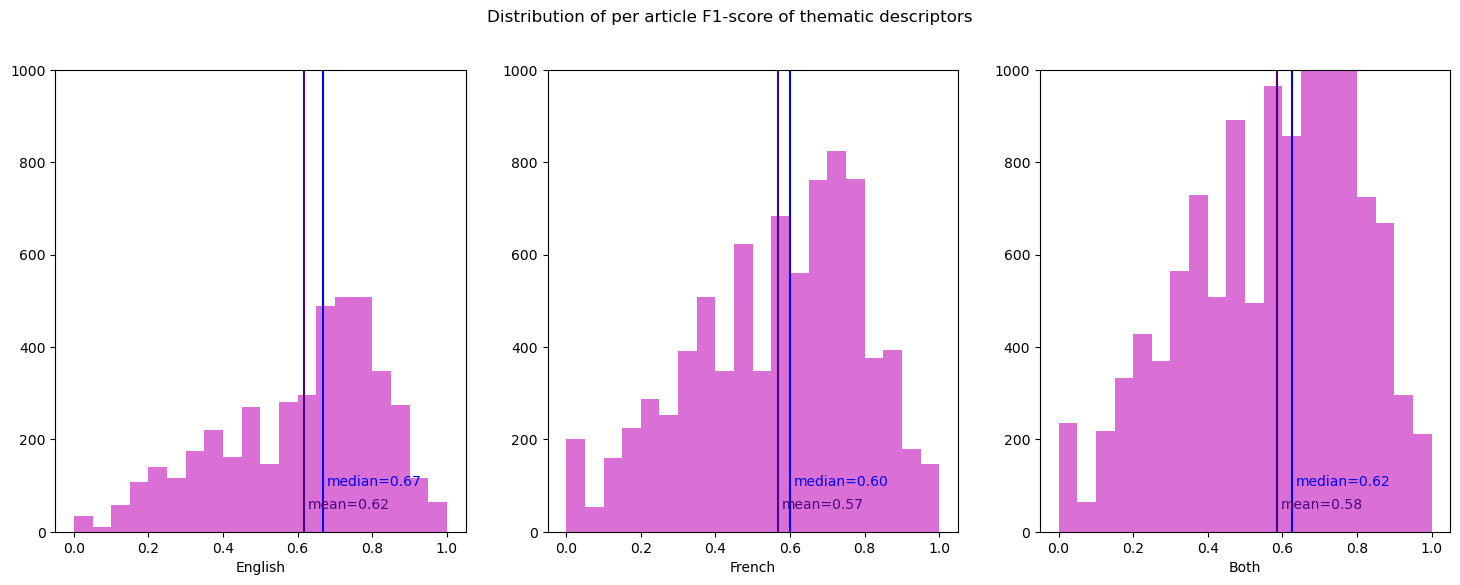

In [55]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Distribution of per article F1-score of thematic descriptors')

def show_hist(i, df_f1):
    mean_f1 = df_f1.F1.mean()
    median_f1 = df_f1.F1.median()

    plt.subplot(1 , 3, i+1)

    plt.hist(df_f1.F1, 20, facecolor='orchid')
    plt.xlabel (['English', 'French', 'Both'][i])
    plt.ylim(0, 1000)
    plt.axvline(mean_f1, color='indigo')
    plt.text(mean_f1 + 0.01, 50, 'mean=%.2f' % mean_f1 , color="indigo")

    plt.axvline(median_f1, color="blue")
    plt.text(median_f1 + 0.01, 100, 'median=%.2f' % median_f1 , color="blue")

for i, df_f1 in enumerate(df_metrics.values()):

    show_hist(i, df_f1)

show_hist(i+1, pd.concat(df_metrics.values() ))
    
plt.show()

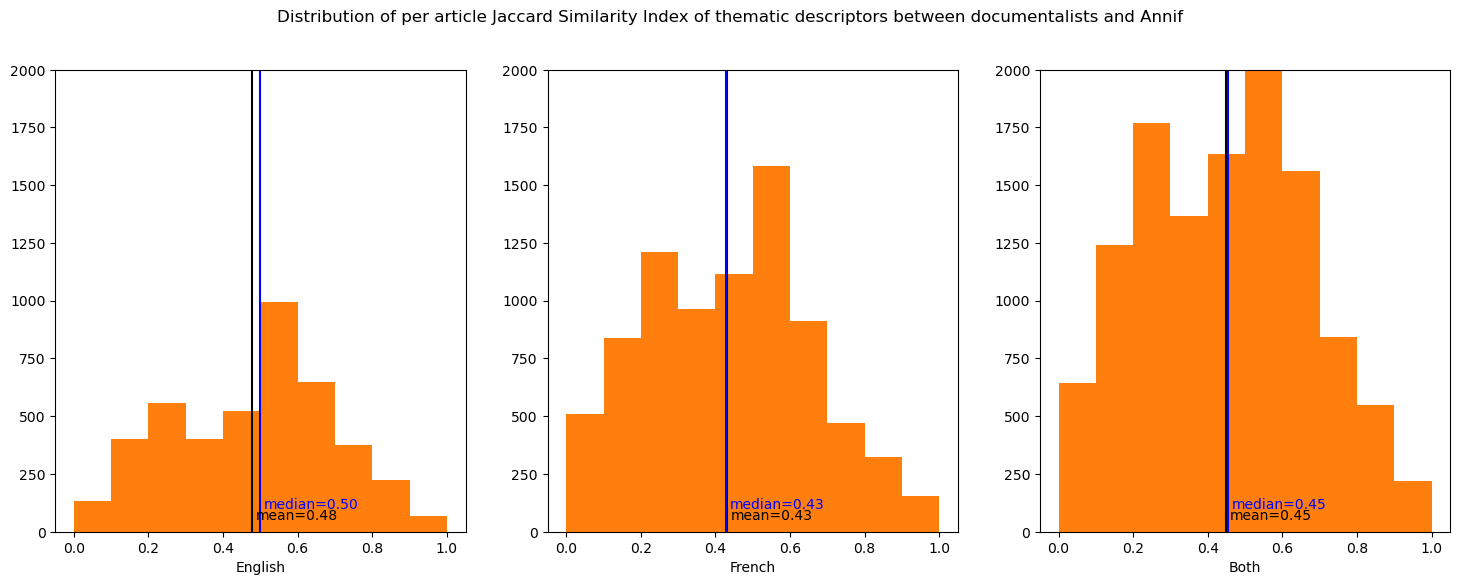

In [56]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Distribution of per article Jaccard Similarity Index of thematic descriptors between documentalists and Annif')

def show_js_hist(i, df_js):
    mean_js = df_js.JaccardIndex.mean()
    median_js = df_js.JaccardIndex.median()

    plt.subplot(1 , 3, i+1)

    plt.hist(df_js.JaccardIndex, 20, facecolor='orchid') ### Why did it stop working??
    plt.xlabel (['English', 'French', 'Both'][i])
    plt.ylim(0, 2000)
    plt.axvline(mean_js, color='black')
    plt.text(mean_js + 0.01, 50, 'mean=%.2f' % mean_js , color="black")
    
    plt.axvline(median_js, color="blue")
    plt.hist(df_js.JaccardIndex, 10)
    plt.text(median_js + 0.01, 100, 'median=%.2f' % median_js , color="blue")
    
for i, df_js in enumerate(df_metrics.values()):
    show_js_hist(i, df_js)

show_js_hist(i+1, pd.concat(df_metrics.values()) )

plt.show()

#### Calculate statistics @10

In [57]:
topK = 11
df_metrics_at10 = {}

for lang in ['en', 'fr']:
    df_metrics_at10[lang] = query_metrics(lang, broader=(0,0), topK=topK)
df_summary_at10 = summary_dataframe(df_metrics_at10, col_suffix='@10')

#pd.options.display.float_format = '{:,.2f}'.format
#df_summary_at10.head()    

en (4323, 9)
fr (8086, 9)


#### Calculate statistics @5

In [59]:
topK = 6
df_metrics_at5 = {}

for lang in ['en', 'fr']:
    df_metrics_at5[lang] = query_metrics(lang, broader=(0,0), topK=topK)
df_summary_at5 = summary_dataframe(df_metrics_at5, col_suffix='@5')

#pd.options.display.float_format = '{:,.2f}'.format
#df_summary_at5.head()   

en (4323, 9)
fr (8086, 9)


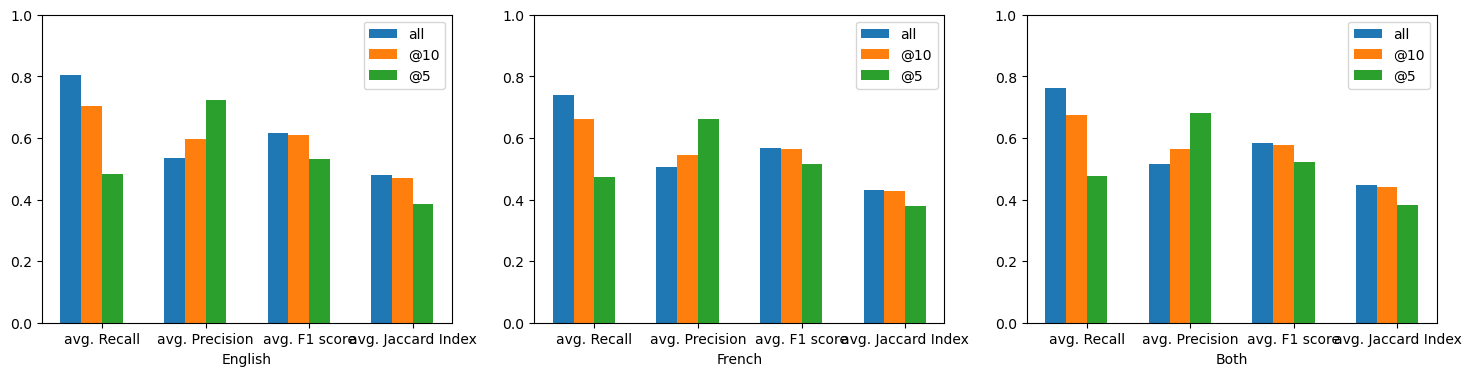

In [61]:
fig = plt.figure(figsize=(18, 4))
#fig.suptitle('Distribution of per article F1-score of thematic descriptors')

def compare_metrics(i , row_num):
    metrics_labels = ['avg. Recall', 'avg. Precision', 'avg. F1 score', 'avg. Jaccard Index']

    x = np.arange(len(metrics_labels))  # the label locations
    width = 0.20  # the width of the bars

    plt.subplot(1 , 3, i+1)
    
    plt.bar(x - width/2*3, df_summary.iloc[row_num,:], width=width, label='all')
    plt.bar(x - width/2, df_summary_at10.iloc[row_num,:], width=width, label='@10')
    plt.bar(x + width/2, df_summary_at5.iloc[row_num,:], width=width, label='@5')
    plt.xticks(x, metrics_labels)
    plt.xlabel (['English', 'French', 'Both'][i])
    plt.ylim(0, 1)
    plt.legend(loc='upper right')

compare_metrics(0, 0)
compare_metrics(1, 1)
compare_metrics(2, 2)

plt.show()

In [83]:
table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
pd.concat([df_summary.transpose(), df_summary_at10.transpose(), df_summary_at10.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary.columns.sort_values(), ['', '@10', '@5']])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different number of autonatically predicted descriptors') \
     .highlight_max(subset='avg. F1 score', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightblue', axis=1)

CONCLUSION: Taking top K of the Annif descriptors improves the precision but reduces the recall more significantly. 

#### Calculate statistic including immediate parents

In [73]:
topK = 100
broader= (0,1)

df_metrics_with_parents = {}

for lang in ['en', 'fr']:
    df_metrics_with_parents[lang] = query_metrics(lang, broader=broader, topK=topK)

df_summary_with_parents = summary_dataframe(df_metrics_with_parents, col_suffix=' (+parent)')

#pd.options.display.float_format = '{:,.2f}'.format
#df_summary_with_parents.head()   

en (4323, 9)
fr (8086, 9)


#### Calculate statistic including ancestors  

In [84]:
topK = 100
broader= (0,20)

df_metrics_with_ancestors = {}

for lang in ['en', 'fr']:
    df_metrics_with_ancestors[lang] = query_metrics(lang, broader=broader, topK=topK)

df_summary_with_ancestors = summary_dataframe(df_metrics_with_ancestors, col_suffix=' (+parents)')

#pd.options.display.float_format = '{:,.2f}'.format
#df_summary_with_ancestors.head()   

en (4323, 9)
fr (8086, 9)


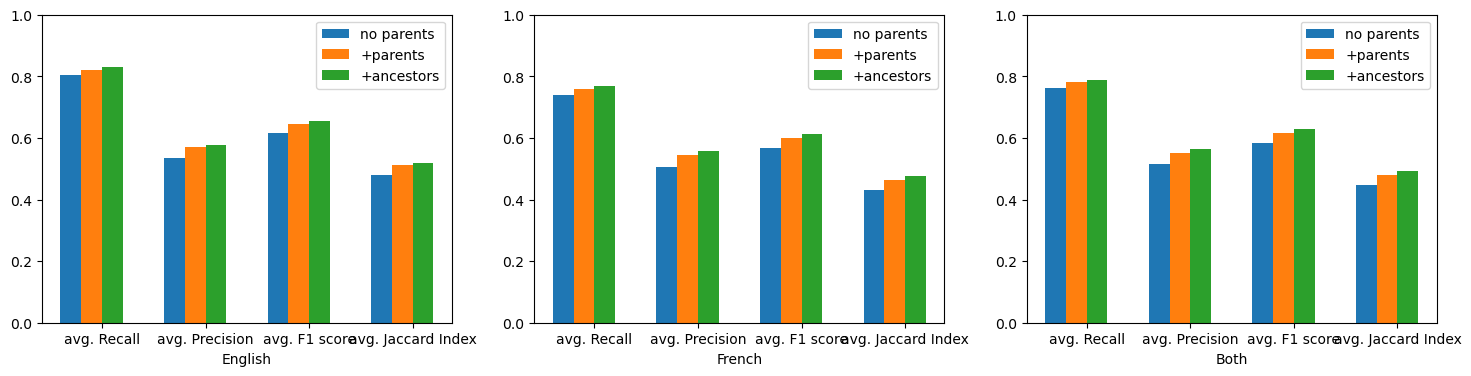

In [85]:
fig = plt.figure(figsize=(18, 4))
#fig.suptitle('Distribution of per article F1-score of thematic descriptors')

def compare_metrics_parents(i , row_num):
    metrics_labels = ['avg. Recall', 'avg. Precision', 'avg. F1 score', 'avg. Jaccard Index']

    x = np.arange(len(metrics_labels))  # the label locations
    width = 0.20  # the width of the bars

    plt.subplot(1 , 3, i+1)
    
    plt.bar(x - width/2*3, df_summary.iloc[row_num,:], width=width, label='no parents')
    plt.bar(x - width/2, df_summary_with_parents.iloc[row_num,:], width=width, label='+parents')
    plt.bar(x + width/2, df_summary_with_ancestors.iloc[row_num,:], width=width, label='+ancestors')
    plt.xticks(x, metrics_labels)
    plt.xlabel (['English', 'French', 'Both'][i])
    plt.ylim(0, 1)
    plt.legend(loc='upper right')

compare_metrics_parents(0, 0)
compare_metrics_parents(1, 1)
compare_metrics_parents(2, 2)

plt.show()

In [86]:
#    [{'selector': 'thead',
#      'props': [('background-color', 'lightblue') ]}]
table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]

pd.concat([df_summary.transpose(), df_summary_with_parents.transpose(), df_summary_with_ancestors.transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([df_summary.columns.sort_values(), ['', '(+parents)', '(+ancestors)']])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Compare metrics for different levels of thesaurus hierarchies') \
     .highlight_max(subset='avg. F1 score', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightblue', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightblue', axis=1)


CONCLUSION: including the thesaurus ancestors along with the descriptors indeed increases the quality metrics.

## Per descriptor statistics 

In [30]:
query_descriptors_count_templ = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos:   <http://www.w3.org/2008/05/skos-xl>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

SELECT ?uri ?descriptorLabel ?indexer
      (count(distinct ?paper) as ?cnt)
      (max(?gn) as ?isGeo)
WHERE {
	?descriptor a issa:ThematicDescriptorAnnotation;
    oa:hasBody ?uri;
    oa:hasTarget ?paper;
    prov:wasAttributedTo ?indexer.
    FILTER (?indexer = %s) # issa:AgritropDocumentalist | issa:AnnifSubjectIndexer
  
  OPTIONAL {
        ?uri skosxl:prefLabel/skosxl:literalForm ?descriptorLabel.
        FILTER langMatches(lang(?descriptorLabel), "en" )
        
        BIND ( EXISTS {?gnUri gn:officialName|gn:alternateName|gn:name|gn:shortName ?descriptorLabel } as ?gn)
  }
}
group by  ?uri ?descriptorLabel ?indexer
order by desc(?cnt)
'''

In [32]:
indexers = {'human' : 'issa:AgritropDocumentalist',
            'annif': 'issa:AnnifSubjectIndexer'}
df_descr_count={}

for key, value in indexers.items():
    print(key, end=' ')
    df_descr_count[key] = sparql_service_to_dataframe(issa_agritrop_endpoint, query_descriptors_count_templ %  indexers[key])
    df_descr_count[key].dropna(inplace=True)
    df_descr_count[key] = df_descr_count[key].astype({'cnt': 'int', 'isGeo': 'int'})
    print(indexers[key] , df_descr_count[key].shape)



human issa:AgritropDocumentalist (7894, 5)
annif issa:AnnifSubjectIndexer (7895, 5)


In [47]:
cols = df_descr_count.keys()

df_descr_summary=pd.DataFrame(columns=cols)

for indexer in df_descr_count:
    df_descr_summary.loc['unique count', indexer] = df_descr_count[indexer].cnt.shape[0]
    df_descr_summary.loc['total count', indexer] =  df_descr_count[indexer].cnt.sum()
    df_descr_summary.loc['geo count', indexer] =  df_descr_count[indexer].isGeo.sum()


    df_descr_summary.loc['mean frequency', indexer] = df_descr_count[indexer].cnt.mean()
    df_descr_summary.loc['frequency std', indexer] =  df_descr_count[indexer].cnt.std()

    df_descr_summary.loc['% of low frequency', indexer] = df_descr_count[indexer][df_descr_count[indexer].cnt < 2].shape[0] / df_descr_count[indexer].shape[0]
    df_descr_summary.loc['% of high frequency', indexer] = df_descr_count[indexer][df_descr_count[indexer].cnt > 500 ].shape[0] / df_descr_count[indexer].shape[0]


table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
df_descr_summary.transpose() \
                .style.set_table_styles(table_style) \
                .format(precision=2) 


,unique count,total count,geo count,mean frequency,frequency std,% of low frequency,% of high frequency
human,7894,178851,310,22.66,78.60,0.28,0.00
annif,7895,155909,304,19.75,78.82,0.39,0.00


#### Human indexing

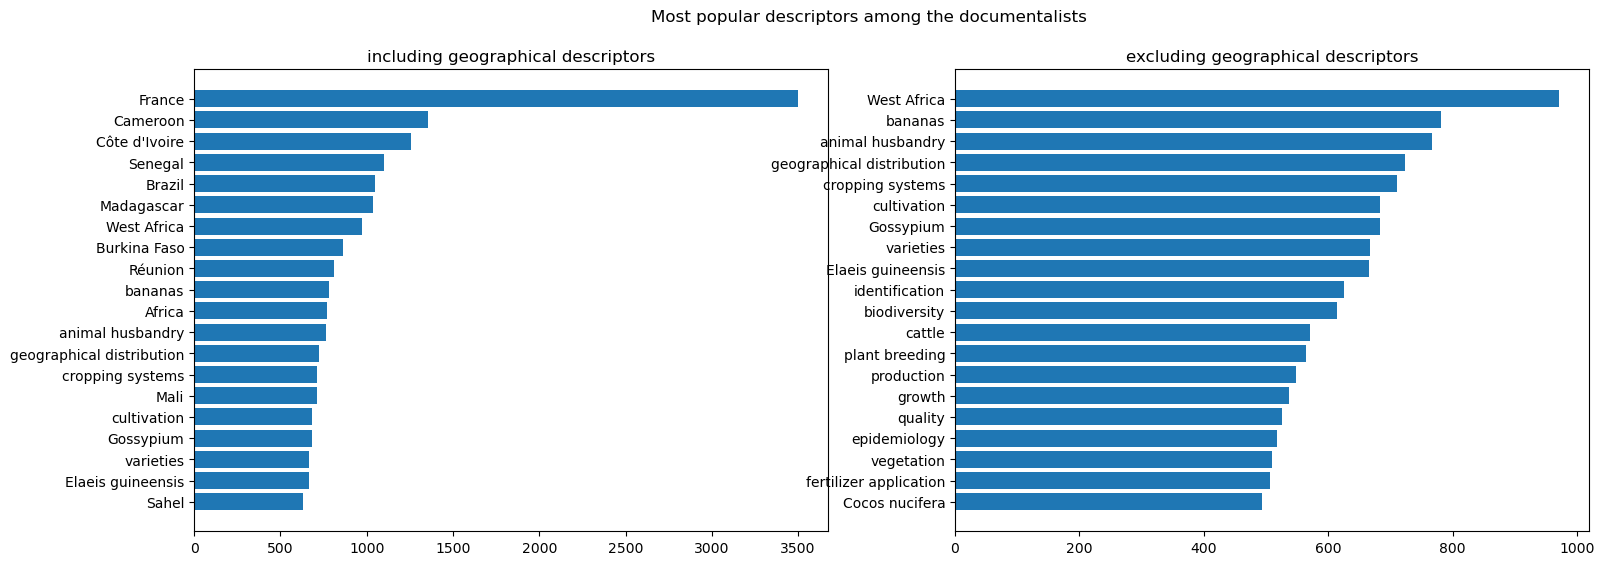

In [23]:
top_20 = df_descr_count['human'].sort_values(by='cnt', ascending=False)[:20]

top_20_non_geo = df_descr_count['human'][df_descr_count['human'].isGeo < 1].sort_values(by='cnt', ascending=False)[:20]

fig = plt.figure(figsize=(18, 6))
fig.suptitle('Most popular descriptors among the documentalists')

plt.subplot(1,2,1)
plt.barh(top_20.descriptorLabel, width=top_20.cnt ) 
plt.gca().invert_yaxis()
plt.title('including geographical descriptors')

plt.subplot(1,2,2)
plt.barh(top_20_non_geo.descriptorLabel, width=top_20_non_geo.cnt) 
plt.gca().invert_yaxis()
plt.title('excluding geographical descriptors')


plt.show()

#### Machine indexing

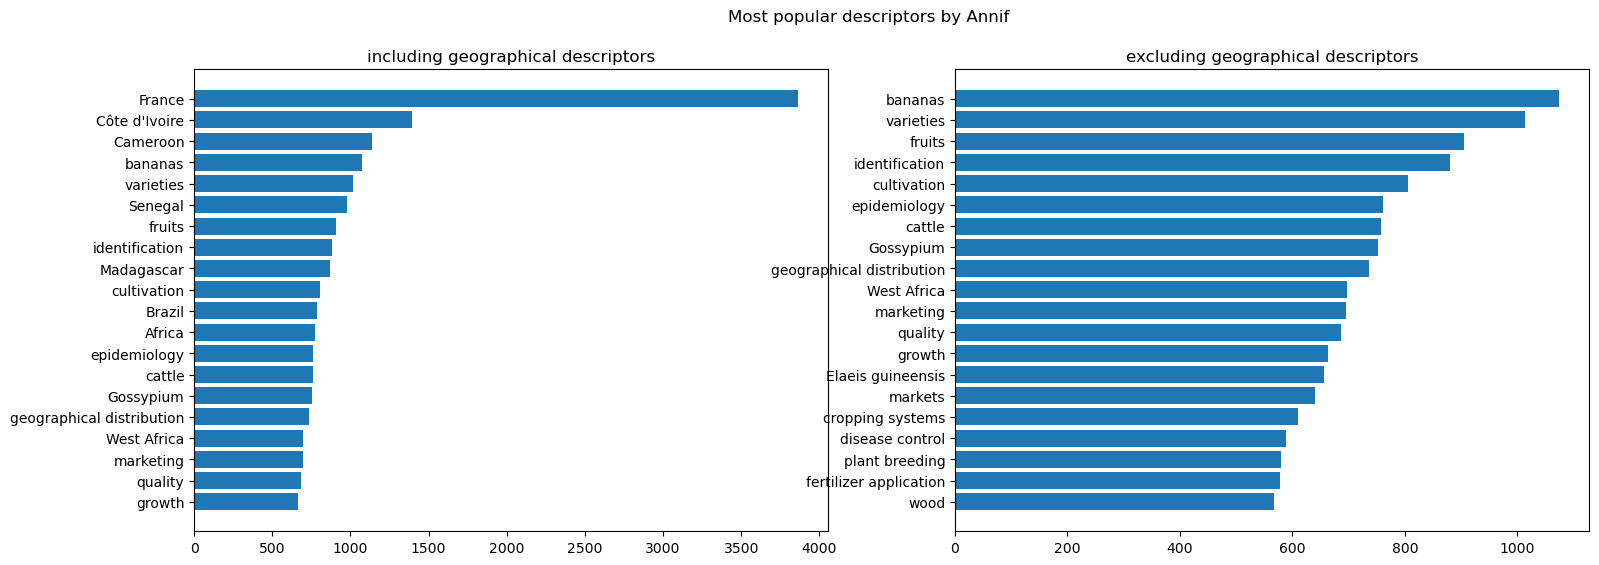

In [33]:
top_20 = df_descr_count['annif'].sort_values(by='cnt', ascending=False)[:20]

df_descr_count_a_top_20_non_geo = df_descr_count['annif'][df_descr_count['annif'].isGeo < 1].sort_values(by='cnt', ascending=False)[:20]

fig = plt.figure(figsize=(18, 6))
fig.suptitle('Most popular descriptors by Annif')

plt.subplot(1,2,1)
plt.barh(top_20.descriptorLabel, width=top_20.cnt) 
plt.gca().invert_yaxis()
plt.title('including geographical descriptors')

plt.subplot(1,2,2)
plt.barh(df_descr_count_a_top_20_non_geo.descriptorLabel, width=df_descr_count_a_top_20_non_geo.cnt) 
plt.gca().invert_yaxis()
plt.title('excluding geographical descriptors')


plt.show()

#### Compare human and automatic indexing

In [87]:
df_merged = df_descr_count['human'].merge(df_descr_count['annif'],
                                            on='uri',
                                            how='outer',
                                            suffixes=['_human', '_annif'] )


df_merged.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cnt_human,"7,894.00",22.66,78.60,1.00,1.00,3.50,13.00,"3,499.00"
isGeo_human,"7,894.00",0.04,0.19,0.00,0.00,0.00,0.00,1.00
cnt_annif,"7,895.00",19.75,78.82,1.00,1.00,2.00,10.00,"3,863.00"
isGeo_annif,"7,895.00",0.04,0.19,0.00,0.00,0.00,0.00,1.00


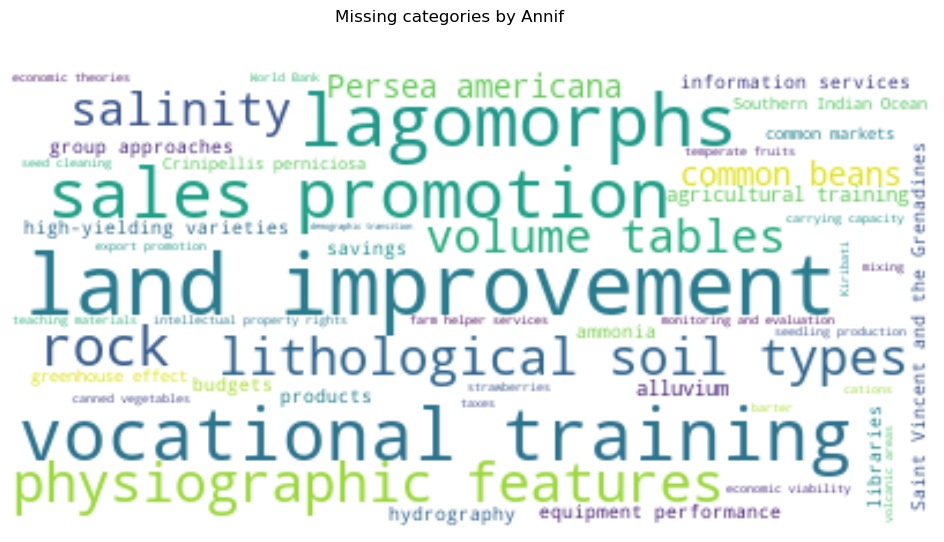

In [36]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

missing_categories = df_merged[df_merged.descriptorLabel_annif.isna()]
missing_categories.shape

freq = dict(zip(missing_categories.descriptorLabel_human, missing_categories.cnt_human)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)

# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Missing categories by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

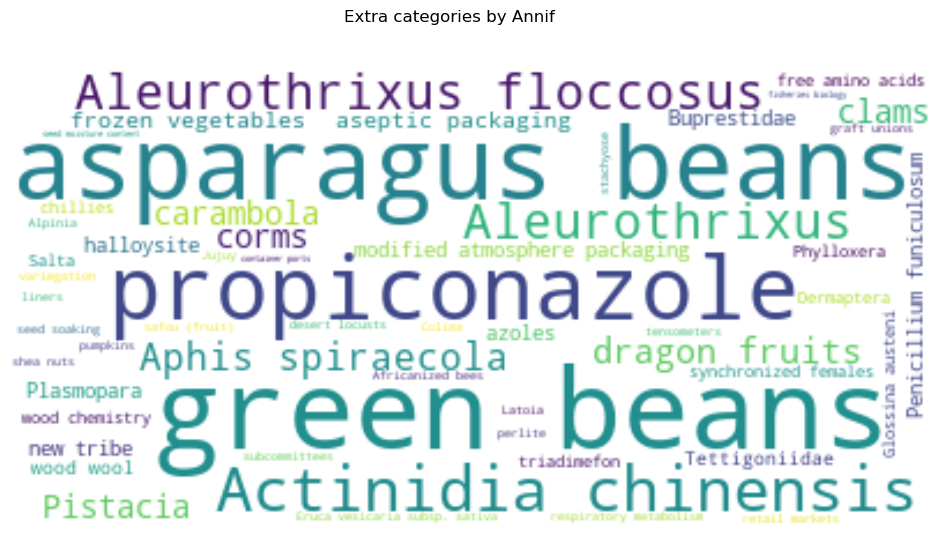

In [37]:
extra_categories = df_merged[df_merged.descriptorLabel_human.isna()]
extra_categories.shape

freq = dict(zip(extra_categories.descriptorLabel_annif, extra_categories.cnt_annif)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)


# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Extra categories by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

CONCLUSION: Annif had missed more general descriptors such as *land improvement* or *vocational training* and added more precise descriptors like *green beens* or *asparagus beans*.  

#### Compare Geographical descriptors

(52, 9)


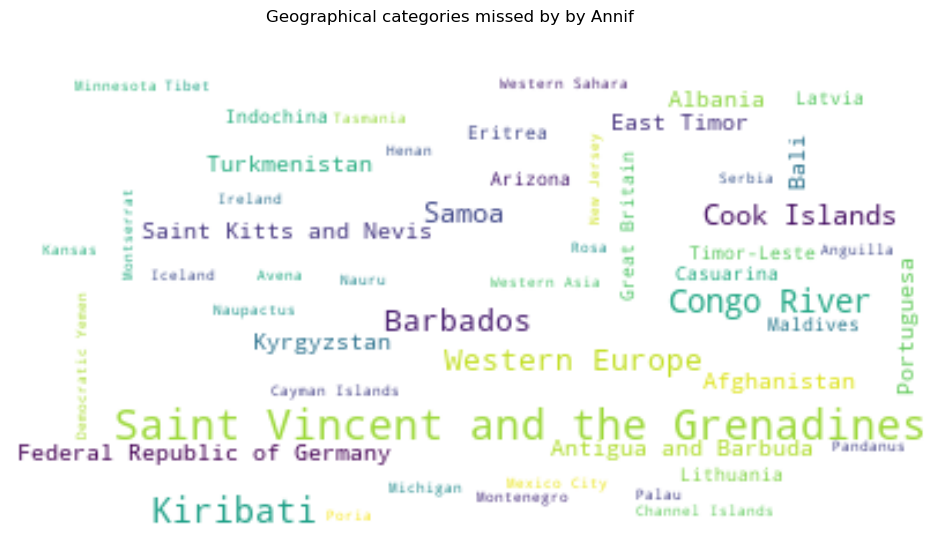

In [43]:
missing_categories_geo = missing_categories[missing_categories.isGeo_human == 1]
print(missing_categories_geo.shape)

freq = dict(zip(missing_categories_geo.descriptorLabel_human, missing_categories_geo.cnt_human)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)

# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Geographical categories missed by by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(46, 9)


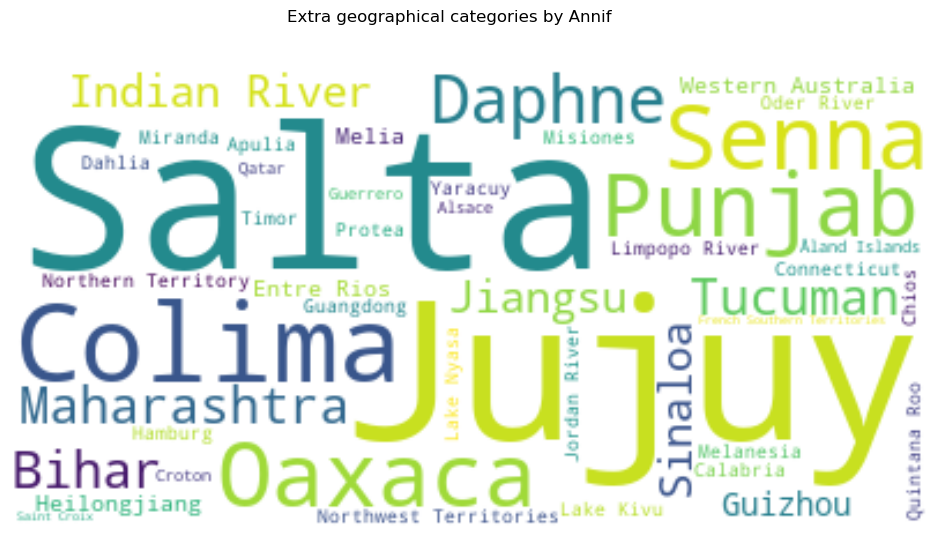

In [44]:
extra_categories_geo = extra_categories[extra_categories.isGeo_annif == 1 ]
print(extra_categories_geo.shape)

freq = dict(zip(extra_categories_geo.descriptorLabel_annif, extra_categories_geo.cnt_annif)) 
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)


# Display the generated image:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Extra geographical categories by Annif')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

CONCLUSION: It seems that Annif had missed some multi-word geographical locations. Can't say much about the extra geographical categories except that they are not occured more than twice.